# IBM Data Science Capstone Notebook
# Buffalo, NY: Battle of Neighborhoods
## Dan Weber 
### 7/8/2020

In this notebook we will scrape data and use it for analysis 

First we need to import and install necessary libraries

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

Next we import BeautifulSoup to grab the data

In [2]:
from bs4 import BeautifulSoup

In [3]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Buffalo,_New_York").text

In [4]:
soup = BeautifulSoup(data, 'html.parser')

Now that we have our data requested and parsed it can be made into a dataframe 

In [5]:
neighborhoodList = []

In [6]:
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [7]:
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})

kl_df.head()

,Neighborhood
0,"Allentown, Buffalo"
1,"Black Rock, Buffalo"
2,"Broadway-Fillmore, Buffalo"
3,Broderick Park
4,Buffalo Theatre District


In [8]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : [ 'Allentown', 'Black Rock', 'Broadway-Fillmore', 'Broderick Park', 'Buffalo Theatre District', 'Canalside', 'Central Park', 'Cold Springs', 'Delaware District', 'East Lovejoy', 'East Side', 'Elmwood Village', 'Fruit Belt', 'Kensington', 'Larkinville', 'Lower West Side', 'North Buffalo', 'North Park', 'Riverside', 'Schiller Park'
                  , 'South Buffalo', 'University Heights', 'Upper West Side'],

'Latitude' : [ '42.899444', '42.935', '42.895972', '42.9149', '42.891389', '42.891389', '42.9441', '42.916111', '42.905556', '42.889444', '42.9', '42.900391', '42.898175', '42.929', '42.8751', '42.9025', '42.9367', '42.947717', '42.947427', '42.912222', '42.847', '42.955392', '42.9347'],


'Longitude' : [ '-78.879722', '-78.9', '-78.844556', '-78.9031', '-78.8725', '-78.8725', '-78.8419', '-78.8575', '-78.873056', '-78.812778', '-78.833333', '-78.877415', '-78.858175', '-78.8502', '-78.8519', '-78.890833', '-78.8718', '-78.85586', '-78.905489', '-78.806111', '-78.824', '-78.827633', '-78.8839'] } )

In [32]:
(coordinates_df)

,Neighborhood,Latitude,Longitude
0,Allentown,42.899444,-78.879722
1,Black Rock,42.935,-78.9
2,Broadway-Fillmore,42.895972,-78.844556
3,Broderick Park,42.9149,-78.9031
4,Buffalo Theatre District,42.891389,-78.8725
5,Canalside,42.891389,-78.8725
6,Central Park,42.9441,-78.8419
7,Cold Springs,42.916111,-78.8575
8,Delaware District,42.905556,-78.873056
9,East Lovejoy,42.889444,-78.812778


Now the list of Buffalo Neighborhoods is in a datframe with the corresponding lat and long values

Using this data, we can make use of Foursquare Venue Information to Analyze 

In [33]:
CLIENT_ID = '1WCI4HF0ORWBIJZ3PCE0DIJNJO3S2NBXCOWSAJ2XB2P3HJVC' # Foursquare ID
CLIENT_SECRET = 'KQGSTPTE2TO1TPOJKEVAVNDKX52YVC3TEMBCSZMZ1N03NMNS' # Foursquare Secret
VERSION = '20180605'

Now to send the request for Venue Data 

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
               CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, 3000, 200)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.extend([
            [name, v['venue']['name'], v['venue']['id'],
            v['venue']['location']['lat'], v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']]
        for v in results])

    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Region', 'Venue', 'Venue ID', 'Venue Latitude', 'Venue Longitude', 'Venue Primary Category']
    
    return(nearby_venues)

In [36]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    
   
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
   
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
   
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [38]:
venues_df = pd.DataFrame(venues)


venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df

(1753, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Allentown,42.899444,-78.879722,Allen Burger Venture,42.899567,-78.876494,Burger Joint
1,Allentown,42.899444,-78.879722,Allen Street Hardware Cafe,42.899528,-78.878980,Bar
2,Allentown,42.899444,-78.879722,Betty's Restaurant,42.896709,-78.878372,Breakfast Spot
3,Allentown,42.899444,-78.879722,The Melting Point,42.899465,-78.879055,Sandwich Place
4,Allentown,42.899444,-78.879722,Kleinhans Music Hall,42.901970,-78.883272,Concert Hall
5,Allentown,42.899444,-78.879722,Billy Club,42.899463,-78.878553,New American Restaurant
6,Allentown,42.899444,-78.879722,Grindhaus Cafe,42.899451,-78.876023,Vegetarian / Vegan Restaurant
7,Allentown,42.899444,-78.879722,PAUSA Art House,42.900092,-78.879893,Concert Hall
8,Allentown,42.899444,-78.879722,Fat Bob's Smokehouse,42.897932,-78.873498,BBQ Joint
9,Allentown,42.899444,-78.879722,Founding Fathers,42.895818,-78.874819,American Restaurant


We now have a complete list of venues, their coordinates, and details for each

In [39]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 193 uniques categories.


In [41]:
venues_df['VenueCategory'].unique()

array(['Burger Joint', 'Bar', 'Breakfast Spot', 'Sandwich Place',
       'Concert Hall', 'New American Restaurant',
       'Vegetarian / Vegan Restaurant', 'BBQ Joint',
       'American Restaurant', 'Mexican Restaurant', 'Poutine Place',
       'Piercing Parlor', 'Massage Studio', 'Cocktail Bar',
       'French Restaurant', 'Coffee Shop', 'Steakhouse',
       'Performing Arts Venue', 'Italian Restaurant', 'Music Venue',
       'Event Space', 'Food Court', 'Latin American Restaurant',
       'Hot Dog Joint', 'Mediterranean Restaurant', 'Gay Bar', 'Market',
       'Brewery', 'Trattoria/Osteria', 'Gym', 'Wine Bar', 'Bakery',
       'Cheese Shop', 'Hotel', 'Boutique', 'Thai Restaurant',
       'Burmese Restaurant', 'Plaza', 'Beer Bar', 'Sports Bar',
       'Greek Restaurant', 'Sushi Restaurant', 'Beer Store',
       'Wings Joint', 'Eastern European Restaurant', 'Art Gallery',
       'Wine Shop', 'Café', 'Japanese Restaurant', 'Yoga Studio',
       'Food Truck', 'Pizza Place', 'Scenic Looko

In [40]:
"Concert Hall" in venues_df['VenueCategory'].unique()

True

There are 193 unique venue types for our data, and "Concert Hall" is included 

To make sure all of the music venues are included, let's make sure to consider "music venue", "performing arts venue" in our grouping

In [43]:
venues_filter_music = [ 'Concert Hall', 'Music Venue', 'Performing Arts Venue']

In [51]:
buffalo_venues_music = venues_df.loc[venues_df['VenueCategory'].isin(venues_filter_music)]

In [52]:
buffalo_venues_music

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
4,Allentown,42.899444,-78.879722,Kleinhans Music Hall,42.901970,-78.883272,Concert Hall
7,Allentown,42.899444,-78.879722,PAUSA Art House,42.900092,-78.879893,Concert Hall
20,Allentown,42.899444,-78.879722,Shea's Performing Arts Center,42.891931,-78.873288,Performing Arts Venue
22,Allentown,42.899444,-78.879722,Babeville,42.893758,-78.875488,Music Venue
49,Allentown,42.899444,-78.879722,Town Ballroom,42.892372,-78.871587,Music Venue
266,Broderick Park,42.9149,-78.9031,Rumble In The City 2,42.930196,-78.896817,Music Venue
273,Buffalo Theatre District,42.891389,-78.8725,Shea's Performing Arts Center,42.891931,-78.873288,Performing Arts Venue
287,Buffalo Theatre District,42.891389,-78.8725,Babeville,42.893758,-78.875488,Music Venue
288,Buffalo Theatre District,42.891389,-78.8725,Town Ballroom,42.892372,-78.871587,Music Venue
323,Buffalo Theatre District,42.891389,-78.8725,PAUSA Art House,42.900092,-78.879893,Concert Hall


Now let's see how many unique music venues are in our data set 

In [72]:
buffalo_venues_music['VenueName'].unique()

array(['Kleinhans Music Hall', 'PAUSA Art House',
       "Shea's Performing Arts Center", 'Babeville', 'Town Ballroom',
       'Rumble In The City 2', 'Bidwell Summer Concert Series',
       'Buffalo Philharmonic Orchestra at Kleinhans Music Hall',
       'Theatre of Youth', 'Asbury Hall'], dtype=object)

## we now have a list of each unique music venue in our dataset!
### now they can be mapped/researched and used for building a business plan for a new venue

In [88]:
map_venues_music = folium.Map(location=[coordinates_df.iloc[0, 2], coordinates_df.iloc[0, 1]], zoom_start=1)



colors_array = cm.rainbow(np.linspace(0, 1, coordinates_df.shape[0]))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, name, region in zip(buffalo_venues_music['VenueLatitude'],
                                  buffalo_venues_music['VenueLongitude'],
                                  buffalo_venues_music['VenueName'],
                                  buffalo_venues_music['Neighborhood']):
    label = folium.Popup('{}, {}'.format(name, region), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color=rainbow[coordinates_df.index[coordinates_df['Neighborhood'] == neighborhood].tolist()[0]],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues_music)

In [89]:
map_venues_music

# Here we have a map of Buffalo with the music venues marked

We can use the data to create more helpful visualizations 

In [91]:
grouped_venues = buffalo_venues_music.groupby('Neighborhood').count()['VenueName']
grouped_venues

Neighborhood
Allentown                   5
Broderick Park              1
Buffalo Theatre District    5
Canalside                   5
Cold Springs                1
Delaware District           5
Elmwood Village             5
Fruit Belt                  4
Lower West Side             8
North Buffalo               1
Upper West Side             1
Name: VenueName, dtype: int64

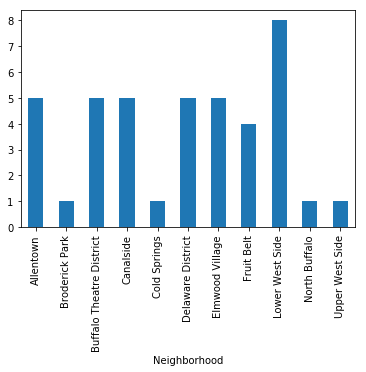

In [93]:
grouped_venues.plot.bar()

## From this we can spot that Upper West Side, Cold Springs, North Buffalo, and Broderick Park Neighborhoods have the least of our venue type

Now that we have extracted, wrangled, parsed, normalized, and displayed the venue data, we can make conclusions and our full report using this information!

Full Report and Presentation also on Github

Coursera 2020 Capstone
Dan Weber 